# Load in data

### Label format
The labels are a 4xN matrix. The rows of the matrix are as follows:
1. single fishes
2. schools of fishes
3. jelly fishes
4. plankton layers

As far as the preprocessing experiments here are concerned, we will just look at the single fish areas for now

In [1]:
data_file = '../../Box/Data/GulfOfMexico/GoM Classifier Data/CLASSIFICATION_DATA_09-24.mat';
classification_data = load(data_file);
xpol_data = classification_data.labeled_xpol_data(1:1000,:);
labels = classification_data.labeled_xpol_data(1001:1004,:);

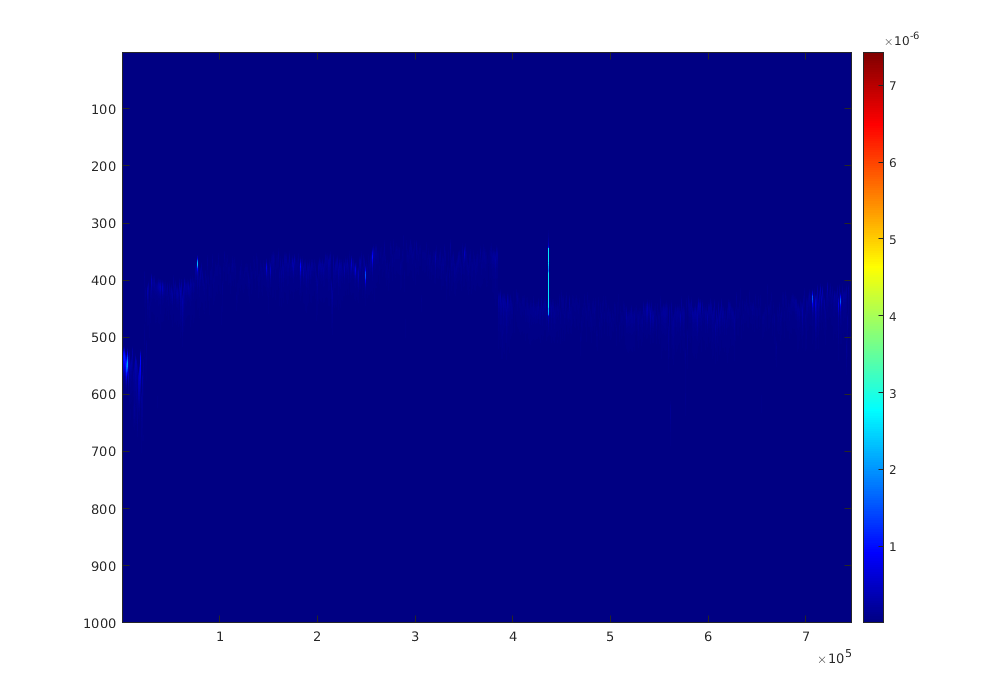

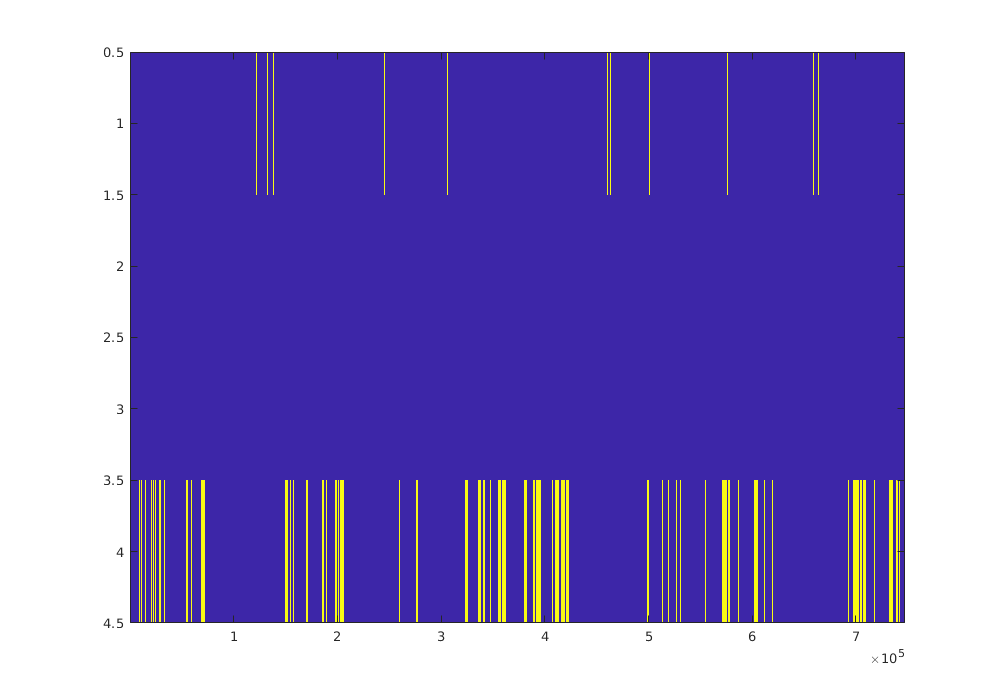

In [3]:
%plot -s 1000,700
imagesc(xpol_data)
colorbar
colormap('jet')

figure
imagesc(labels)

# Standard preprocessing
- find the surface of the water
- normalize the data so the water surface is constant
- dimensionality reduction

## Preprocessing notes/questions
It looks like the maximum lidar return does not always correspond to the actual water surface. At least in cross-polarized data, anyway. Mike Roddewig used co-polarized data to find the water surface in the Yellowstone Lake flights. **Do we have co-polarized data?**

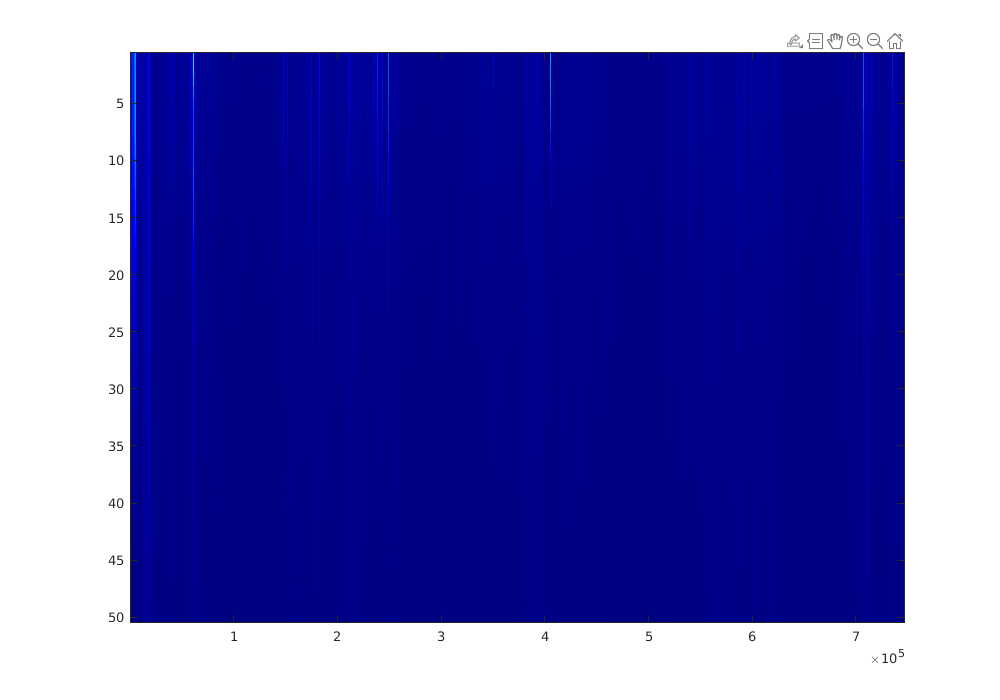

In [3]:
% TODO: I think the surface finding algorithm needs to be fixed; this doesn't seem to be working very well so far
surface_idx = find_water_surface(xpol_data);
xpol_normalized = normalize_surface_height(xpol_data, surface_idx, 0);

% TODO: use a physics-motivated number for image depth, i.e. how far the lidar can penetrate the water
xpol_normalized = xpol_normalized(1:50, :);

imagesc(xpol_normalized)
colormap('jet')

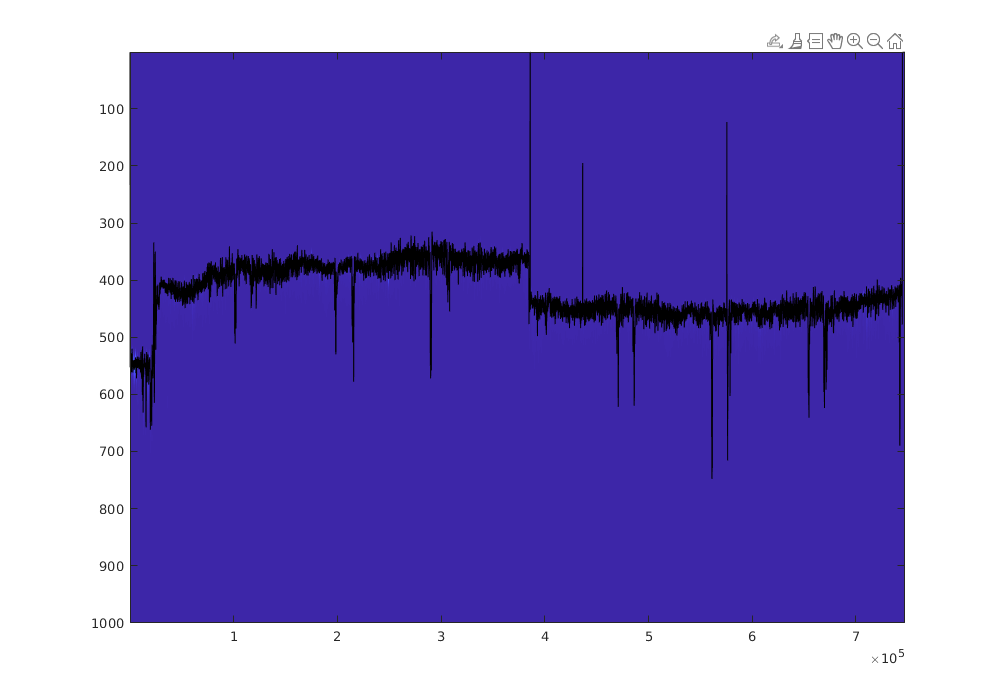

In [4]:
imagesc(xpol_data)
hold on
plot(surface_idx, 'k')

# Grab a section of data with fish in it
Since the image is so large, I will focus on a smaller area to make visualization easier

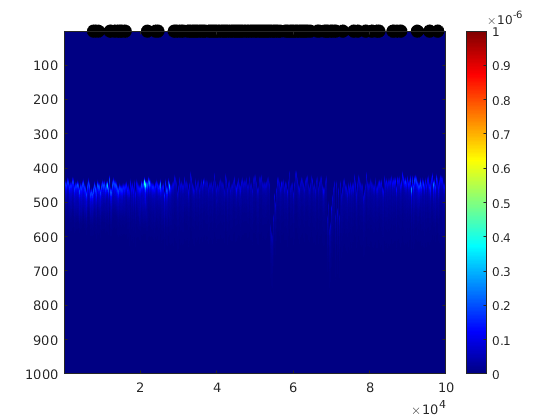

In [2]:
% use "%plot native" to make plots pop up in an interactable matlab gui; "%plot inline" can be used to make plots inline again
fishes = find(labels(1,:));
indices = 6e5:7e5;
fish_subset_data = xpol_data(:, indices);
fish_subset_labels = labels(1, indices);
imagesc(fish_subset_data)
colormap('jet')
colorbar
caxis([0, 1e-6])
hold on
scatter(find(fish_subset_labels), ones(1, length(find(fish_subset_labels))), 100, 'k', 'filled')
hold off

# Median filtering
The idea behind using a median filter is to help remove uninteresting background information. A sliding window is used to get local median estimates. The window length should be motivated by the length scale we expect to see interesting maritime objects (e.g. fish) on; I'm not sure what this scale is right now.

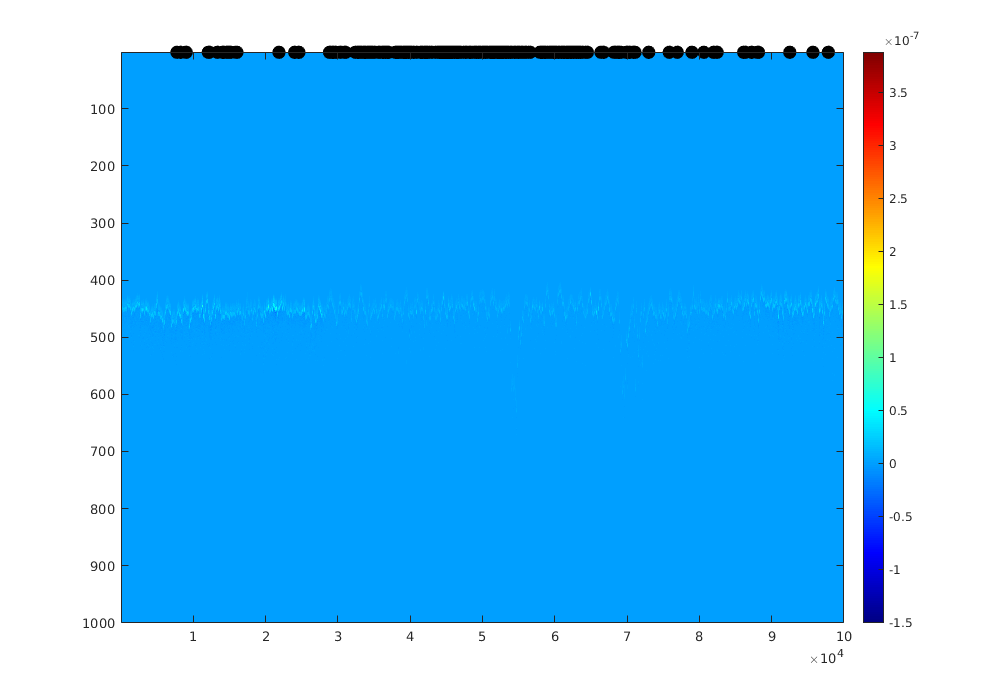

In [8]:
window_length = 20;
fish_subset_median = movmedian(fish_subset_data, window_length);
fish_subset_minus_median = fish_subset_data - fish_subset_median;
imagesc(fish_subset_minus_median)
colormap('jet')
colorbar
hold on
scatter(find(fish_subset_labels), ones(1, length(find(fish_subset_labels))), 100, 'k', 'filled')

# Moving standard deviation
If fish are identified by abrupt changes in returned energy (I'm not 100% sure this is an identifying feature), then the a moving standard deviation should give us a measure of how much "change" there has been in a local region.

The median is already removed before taking the standard deviation, but this doesn't have to be the case. The standard deviation results don't seem particularly ellucidating.

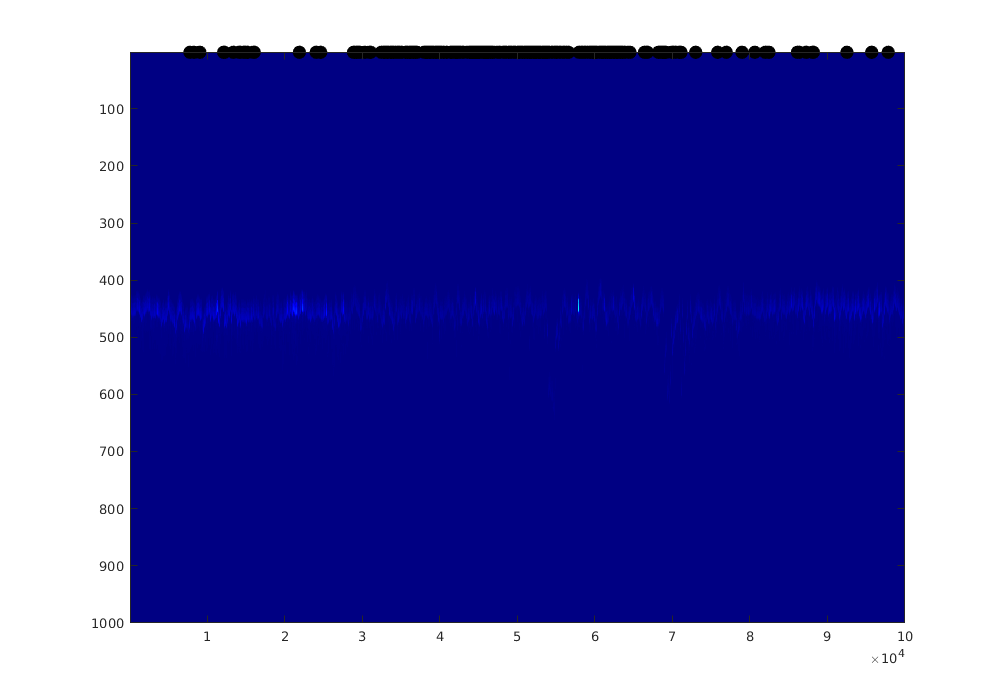

In [7]:
window_length = 20;
fish_subset_std = movstd(fish_subset_minus_median, window_length);
imagesc(fish_subset_std)
colormap('jet')
hold on
scatter(find(fish_subset_labels), ones(1, length(find(fish_subset_labels))), 100, 'k', 'filled')

# MTI filtering
These filters are common in radar processing for moving target indication (MTI); they are commonly used to remove background clutter between radar shots. 

The first one is a simple first difference filter: $y[n] = x[n] - x[n-1]$

The second one is a 2nd order highpass filter, known as a three-pulse canceller: $y[n] = x[n] - 2x[n-1] + x[n-2]$

## 1st order MTI

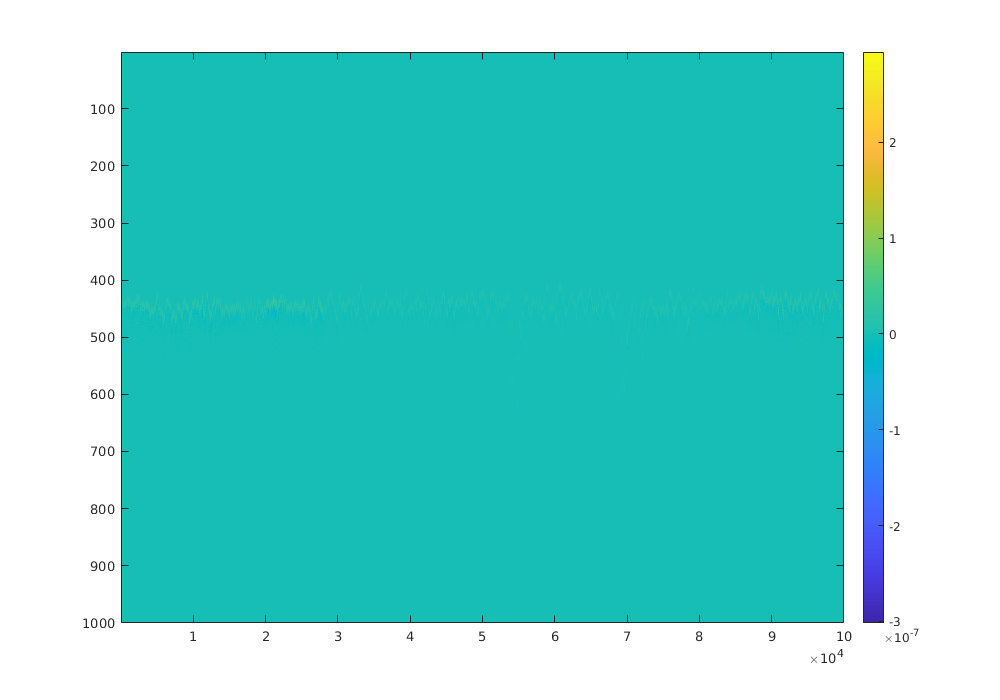

In [5]:
coeff = [1 -1];
fish_subset_mti1 = filter(coeff, 1, fish_subset_data);
imagesc(fish_subset_mti1)
colorbar

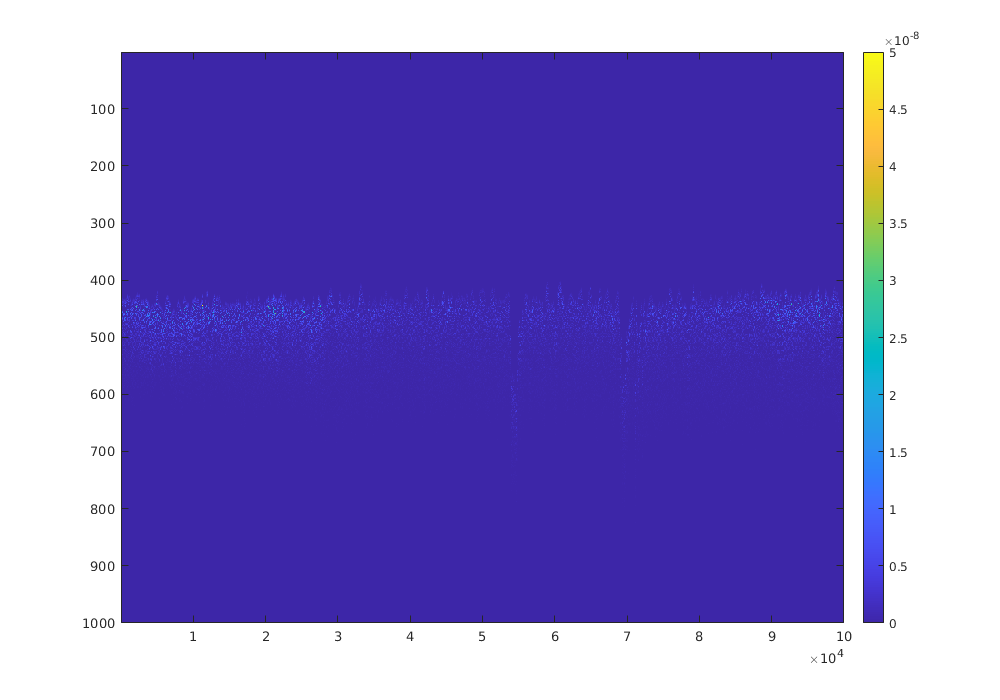

In [8]:
coeff = [1 -2 1];
fish_subset_mti3 = filter(coeff, 1, fish_subset_data);
imagesc(fish_subset_mti3);
colorbar
caxis([0 0.5e-7])

The three-pulse canceller doesn't seem very effective